# **See full article on [Meduim](https://medium.com/@tharindumadhusanka99/llama3-rag-on-google-colab-73c43aa53281)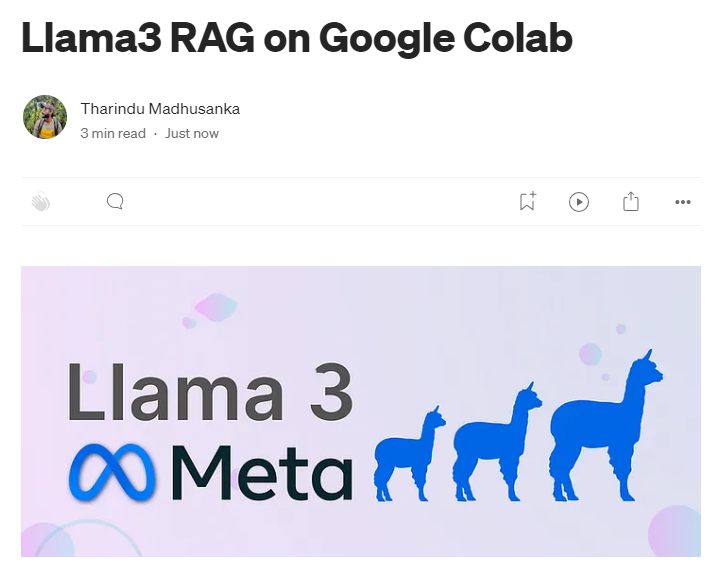**

In [1]:
# %load_ext colabxterm

In [2]:
# type these two lines of codes in below terminal after run the cell (%xterm):
# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve & ollama pull llama3 & ollama pull nomic-embed-text

In [3]:
# %xterm

In [4]:
# !pip -qq install langchain
# !pip -qq install langchain-core
# !pip -qq install langchain-community

In [1]:
#Lendo do arquivo salvo...
from tqdm import tqdm
import pandas as pd
import numpy as np
np.float_ = np.float64
data = pd.read_csv('EIOS_train.csv')
train = pd.DataFrame(data)
data = pd.read_csv('EIOS_test.csv')
test = pd.DataFrame(data)
print(train.label.value_counts())

label
Arboviroses                                               1287
Doenças Respiratórias                                     1093
Vigilância dos Desastres                                  1050
Zoonoses                                                   635
Vigilância dos Acidentes e Violências                      471
Assistência                                                455
Infecções Sexualmente Transmissíveis (IST)                 350
Imunização                                                 310
Imunoprevenível                                            249
Evento de Saúde Pública (ESP)                              209
Vigilância Animal                                          206
Doença Crônica Não Transmissível (DCNT)                    185
Doenças de Transmissão Hídrica e Alimentar (DTHA)          156
Doença Crônica Transmissível (DCT)                         133
Alusivo/ Informativo                                        94
Meningites                                       

In [5]:
from langchain_community.llms import Ollama
llm = Ollama(model = "llama3.1")

In [6]:
llm.invoke("what is the Meaning of life")

"The question of the meaning of life is one of the most profound and enduring questions in human history. It has been debated by philosophers, theologians, scientists, and thinkers across cultures and centuries.\n\nThere is no one definitive answer to this question, as it depends on various perspectives, values, and beliefs. However, here are some possible interpretations:\n\n1. **Existentialist perspective**: From an existentialist point of view, the meaning of life is not predetermined or given by external forces. Instead, individuals must create their own purpose and significance through their choices, experiences, and relationships.\n2. **Philosophical perspective**: Philosophers have proposed various answers to this question over time:\n\t* **Plato's theory**: According to Plato, the meaning of life is to ascend from the world of sensory experience to the realm of abstract thought, where one can contemplate eternal truths and achieve spiritual enlightenment.\n\t* **Aristotle's con

In [7]:
prompt = "Classifique o texto do campo Questão: em uma das seguintes classes com relação ao contexto da área da saúde: 1) Relevante ou 2) Irrelevante, apenas as palavras 'Relevante' ou 'Irrelevante' devem ser utilizadas para a classe. A resposta deve vir com uma justificativa para a classe informada. A saída deve ser padronizada no formato de um dicionário em python como segue: {classe: Relevante ou Irrelevante para o contexto da área da saúde, justificativa: texto com a justificativa da classe}. por exemplo, para questão: 'tenho dores pulmonares afetadas pelo cigarro' a saida deve ser formatada como segue {'classe':'Relevante', 'justificativa':'Texto trata de um problema respiratório relacionado a área da saúde'}."
#response = llm.invoke(prompt+"Questão: hoje eu acordei com dores na gargante como minha filha também.")
response = llm.invoke(prompt+"Questão: minha rua está cheia de buracos.")
print(response)

{ 
  "classe": "Irrelevante", 
  "justificativa": "O texto não se refere a um problema de saúde." 
}


In [9]:
#convert string into dictionary
import ast
dictio = ast.literal_eval(response)
print(dictio)
print(dictio['classe'])

{'classe': 'Irrelevante', 'justificativa': 'O texto não apresenta nenhuma relação com o contexto da área da saúde, tratando-se de um problema urbano ou municipal'}
Irrelevante


In [10]:
# !pip install ollama langchain beautifulsoup4 chromadb gradio -q

In [11]:
# !pip install chromadb

In [11]:
import gradio as gr
import ollama
from bs4 import BeautifulSoup as bs
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.document_loaders import DataFrameLoader

# Load the data from pandas
loader = DataFrameLoader(test, page_content_column="text") #usando o test por ser pequeno
docs = loader.load()
print(docs)

# Split the loaded documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Create Ollama embeddings and vector store
embeddings = OllamaEmbeddings(model="nomic-embed-text")
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)




[Document(metadata={'Unnamed: 0': 3754, 'label': 'Arboviroses'}, page_content='Para desafogar as Unidades de Pronto Atendimento (UPAs), partir de hoje as 29 Unidades Básicas de Saúde (UBS) de Foz do Iguaçu, irão assistir os pacientes classificados com dengue tipo B – casos que demandam acompanhamento diário com exames e hidratação, mas não necessitam internamento. As UPAs darão atenção especial aos casos ainda mais severos da doença (tipo C). Desde o início da epidemia de dengue, no final de fevereiro, houve um aumento expressivo na procura das UPAs, o que resultou em um aumento no tempo de espera dos pacientes.'), Document(metadata={'Unnamed: 0': 1447, 'label': 'Arboviroses'}, page_content='Um homem de 46 anos de idade, portador de diabetes, morreu em Campo Grande no último dia 16 em decorrência da dengue. A informação foi confirmada pela Secretaria do Estado de Saúde (SES) nesta quarta-feira (23), através do boletim epidemiológico. Conforme os dados, o paciente começou a ter os sinto

In [18]:

# Define the function to call the Ollama Llama3 model
def ollama_llm(question, context):

    prompt_specs = "Classifique o texto do campo Questão: em uma das seguintes classes com relação ao contexto da área da saúde: 1) Relevante ou 2) Irrelevante, apenas as palavras 'Relevante' ou 'Irrelevante' devem ser utilizadas para a classe. A resposta deve vir com uma justificativa para a classe informada. A saída deve ser padronizada no formato de um dicionário em python como segue: {'classe': 'Relevante ou Irrelevante para o contexto da área da saúde', 'justificativa': 'texto com a justificativa da classe'}. por exemplo, para questão: 'tenho dores pulmonares afetadas pelo cigarro' a saida deve ser formatada como segue {'classe':'Relevante', 'justificativa':'Texto trata de um problema respiratório relacionado a área da saúde'}."

    formatted_prompt = f"{prompt_specs} Question: {question}\n\nContext: {context}"
    response = ollama.chat(model='llama3.1', messages=[{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']

# Define the RAG setup
#retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 100}) #Variar esse K para encontrar a quantidade ideal
retriever = vectorstore.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5}) #variar o score do trheshold
def rag_chain(question):
    retrieved_docs = retriever.invoke(question)
    formatted_context = "\n\n".join(doc.page_content for doc in retrieved_docs)
    return ollama_llm(question, formatted_context)

# Define the Gradio interface
def get_important_facts(question):
    return rag_chain(question)

In [20]:
import ast
# response = rag_chain("a minha vizinha estar com dor nos olhos após lavar com agua corrente da torneira.")
response = rag_chain("a minha rua está cheia de buracos.")
print(response)

/home/geffte/.local/lib/python3.10/site-packages/langchain_core/vectorstores/base.py:559: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'Unnamed: 0': 557, 'label': 'Vigilância dos Acidentes e Violências'}, page_content='Morreu na manhã desta terça-feira (02), em Campo Grande, Lucas Gabriel Campos, de 40 anos, vítima de queimaduras de segundo enquanto acendia uma chapa. Ele ficou internado por quase um mês, mas evoluiu para uma pneumonia e grave infecção, não resistindo. Conforme boletim de ocorrência, no dia 7 de setembro, ele estava em casa com familiares e amigos fazendo bife na chapa. Em dado momento, ele achou que o fogo já tinha sido apagado e se aproximou para colocar mais álcool no reservatório, provocando uma explosão.'), -208.31346891942002), (Document(metadata={'Unnamed: 0': 974, 'label': 'Vigilância dos Desastres'}, page_content='Uma enorme formação rochosa caiu sobre quatro barcos no estado brasileiro de Minas Gerais na manhã de sábado, dei

{'classe': 'Irrelevante', 'justificativa': 'O texto não se refere à saúde ou a temas médicos.'}


In [26]:
#convert string into dictionary
dictio = ast.literal_eval(response)

In [36]:
def redimensionar_df(df, n):
    data_test = []

    for _, row in df.iterrows():
        data_test.append(row['text'])
        if len(data_test) == n:
            break

    df_data_test = pd.DataFrame(data_test, columns=['text'])
    return df_data_test

In [38]:
df_wrongs = pd.read_csv('imdb.csv')
df_wrongs = redimensionar_df(df_wrongs, 200)
df_test = redimensionar_df(train, 200)

In [42]:
print(len(df_wrongs),len(df_test))

200 200


In [44]:
def run_test(df):
    correct = 0
    for text in tqdm(df['text']):
        response = rag_chain(text)
        response = ast.literal_eval(response)
        choice = response['classe'].lower()
        if choice == 'relevante':
            correct += 1
    return correct

In [46]:
correct_test = run_test(df_test)

  0%|          | 0/200 [00:00<?, ?it/s]/home/geffte/.local/lib/python3.10/site-packages/langchain_core/vectorstores/base.py:559: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'Unnamed: 0': 1373, 'label': 'Arboviroses'}, page_content='“Metade da população de Campo Grande já está protegida pelo Wolbito”, comemora Luciano Moreira, que é líder do Método Wolbachia no Brasil e esteve hoje (15) em Campo Grande, para acompanhar o início da liberação dos mosquitos nos bairros que fazem parte da Fase 4 da implementação do projeto na Capital. O objetivo é reduzir o número de casos de arboviroses transmitidas pelo Aedes aegypti, como Dengue, Zika e Chykungunia. O método é uma parceria entre a Prefeitura Municipal de Campo Grande, Fundação Osvaldo Cruz (Fiocruz), World Mosquito Program Brasil (WMP Brasil) e o governo estadual, que realiza soltura de mosquitos com a bactéria Wolbachia – que está presente em 60% dos insetos na natureza – evitando, assim, o desenvolvi

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
corrects_wrongs = run_test(df_wrongs)

# Interface 

In [ ]:

# Create a Gradio app interface
iface = gr.Interface(
  fn=get_important_facts,
  inputs=gr.Textbox(lines=2, placeholder="Enter your question here..."),
  outputs="text",
  title="RAG with Llama3",
  description="Ask questions about the proveded context",
)

# Launch the Gradio app
iface.launch(share=True)


Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://90f7f027334a171f7a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/home/geffte/.local/lib/python3.10/site-packages/langchain_core/vectorstores/base.py:559: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'Unnamed: 0': 8729, 'label': 'Alusivo/ Informativo'}, page_content='A chegada da frente fria trouxe chuva forte para Campo Grande na manhã desta sexta-feira (24), mas o frio reina durante a tarde com previsão da mínima invertida. Segundo o Inmet (Instituto Nacional de Meteorologia), sensação térmica registrada por volta de 13h foi de 12,2ºC.'), -212.16925953127284), (Document(metadata={'Unnamed: 0': 557, 'label': 'Vigilância dos Acidentes e Violências'}, page_content='Morreu na manhã desta terça-feira (02), em Campo Grande, Lucas Gabriel Campos, de 40 anos, vítima de queimaduras de segundo enquanto acendia uma chapa. Ele ficou internado por quase um mês, mas evoluiu para uma pneumonia e grave infecção, não resistindo. Conforme boletim de ocorrência, no dia 7 de setembro, ele estava em casa com familiares e amigos fazen